<a href="https://colab.research.google.com/github/DiegoDangelo/Desafio_Smattbot/blob/main/Desafio_Smarttbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configurações Iniciais

In [ ]:
#instalar java, spark e finspark
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.2.0/spark-3.2.0-bin-hadoop2.7.tgz
!tar xf spark-3.2.0-bin-hadoop2.7.tgz
!pip install -q findspark

#definir diretórios
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.0-bin-hadoop2.7"

#importar finspark
import findspark
findspark.init()

Inicializar instancia spark

In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master('local[*]').getOrCreate()

Importar arquivos csv

In [11]:
#Baixar arquivos .csv do git smarttbot

!wget https://git.smarttbot.com/recrutamento/analytics-engineer-challenge/-/archive/main/analytics-engineer-challenge-main.zip?path=data
!unzip -j /content/analytics-engineer-challenge-main.zip?path=data -d /content/data

--2021-12-18 13:42:46--  https://git.smarttbot.com/recrutamento/analytics-engineer-challenge/-/archive/main/analytics-engineer-challenge-main.zip?path=data
Resolving git.smarttbot.com (git.smarttbot.com)... 44.195.184.248
Connecting to git.smarttbot.com (git.smarttbot.com)|44.195.184.248|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8032654 (7.7M) [application/zip]
Saving to: ‘analytics-engineer-challenge-main.zip?path=data’

analytics-engineer- 100%[===================>]   7.66M  9.83MB/s    in 0.8s    

2021-12-18 13:42:48 (9.83 MB/s) - ‘analytics-engineer-challenge-main.zip?path=data’ saved [8032654/8032654]

Archive:  /content/analytics-engineer-challenge-main.zip?path=data
685a68b9c484517482138b12afeed1a413d13377
  inflating: /content/data/Person.Person.csv  
replace /content/data/Production.Product.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/data/Production.Product.csv  
  inflating: /content/data/Sales.Customer.csv  
  inflating

In [12]:
#Carregar arquivos, já criando uma TempView para usar no SQL do Spark

person = spark.read.csv('data/Person.Person.csv', sep = ';', header = True)
person.createOrReplaceTempView('Person_Person')

product = spark.read.csv('data/Production.Product.csv', sep = ';', header = True)
product.createOrReplaceTempView('Production_Product')

customer = spark.read.csv('data/Sales.Customer.csv', sep = ';', header = True)
customer.createOrReplaceTempView('Sales_Customer')

order_detail = spark.read.csv('data/Sales.SalesOrderDetail.csv', sep = ';', header = True)
order_detail.createOrReplaceTempView('Sales_SalesOrderDetail')

order_header = spark.read.csv('data/Sales.SalesOrderHeader.csv', sep = ';', header = True)
order_header.createOrReplaceTempView('Sales_SalesOrderHeader')

offer_product = spark.read.csv('data/Sales.SpecialOfferProduct.csv', sep = ';', header = True)
offer_product.createOrReplaceTempView('Sales_SpecialOfferProduct')


# Análise exploratória dos dados

Farei uma análise em superficial, apenas para conhecer melhor a base.

In [ ]:
#Observar estrutura (top 5)

person.show(5)
product.show(5)
customer.show(5)
order_detail.show(5)
order_header.show(5)
offer_product.show(5)

+----------------+----------+---------+-----+---------+----------+----------+------+--------------+---------------------+--------------------+--------------------+--------------------+
|BusinessEntityID|PersonType|NameStyle|Title|FirstName|MiddleName|  LastName|Suffix|EmailPromotion|AdditionalContactInfo|        Demographics|             rowguid|        ModifiedDate|
+----------------+----------+---------+-----+---------+----------+----------+------+--------------+---------------------+--------------------+--------------------+--------------------+
|               1|        EM|        0| NULL|      Ken|         J|   Sánchez|  NULL|             0|                 NULL|"<IndividualSurve...|92C4279F-1207-48A...|2009-01-07 00:00:...|
|               2|        EM|        0| NULL|    Terri|       Lee|     Duffy|  NULL|             1|                 NULL|"<IndividualSurve...|D8763459-8AA8-47C...|2008-01-24 00:00:...|
|               3|        EM|        0| NULL|  Roberto|      NULL|Tamburell

In [ ]:
#Resumo dos dados
person.summary().show()
product.summary().show()
customer.summary().show()
order_detail.summary().show()
order_header.summary().show()
offer_product.summary().show()

+-------+-----------------+----------+---------+-----+---------+----------+--------+------+------------------+---------------------+--------------------+--------------------+--------------------+
|summary| BusinessEntityID|PersonType|NameStyle|Title|FirstName|MiddleName|LastName|Suffix|    EmailPromotion|AdditionalContactInfo|        Demographics|             rowguid|        ModifiedDate|
+-------+-----------------+----------+---------+-----+---------+----------+--------+------+------------------+---------------------+--------------------+--------------------+--------------------+
|  count|            17021|     17021|    17021|17021|    17021|     17021|   17021| 17021|             17021|                17021|               17021|               17021|               17021|
|   mean|9282.652018095294|      null|      0.0| null|     null|      null|    null|  null|0.6312202573291816|                 null|                null|                null|                null|
| stddev|4970.476699

Analisar variáveis importantes para a aplicação

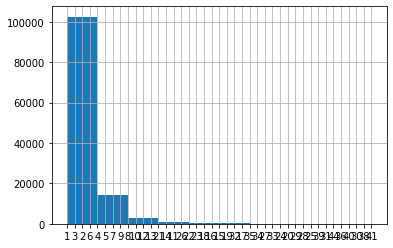

In [26]:
#Histograma 'OrderQty'
order_detail.toPandas().OrderQty.hist()

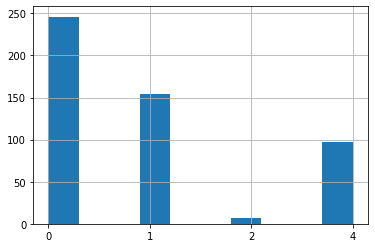

In [29]:
#Histograma 'DaysToManufacture'
product.toPandas().DaysToManufacture.hist()

# Análise dos dados

Escreva uma query que retorna a quantidade de linhas na tabela Sales.SalesOrderDetail pelo campo SalesOrderID, desde que tenham pelo menos três linhas de detalhes

In [ ]:
spark.sql(""" 

SELECT COUNT(DISTINCT t.SalesOrderID)
FROM 
(
  SELECT COUNT(SalesOrderID) OVER(PARTITION BY SalesOrderID) as count,SalesOrderID
  FROM Sales_SalesOrderDetail
) as t
where t.count >= 3 

""").show()

+----------------------------+
|count(DISTINCT SalesOrderID)|
+----------------------------+
|                       12757|
+----------------------------+



Escreva uma query que ligue as tabelas Sales.SalesOrderDetail, Sales.SpecialOfferProduct e Production.Product e retorne os 3 produtos (Name) mais vendidos (pela soma de OrderQty), agrupados pelo número de dias para manufatura (DaysToManufacture).


In [ ]:
spark.sql(""" 

SELECT DaysToManufacture, Name, nu_orders
FROM(
SELECT *,
  ROW_NUMBER() OVER(PARTITION BY b4.DaysToManufacture ORDER BY nu_orders DESC) as posicao
FROM 
  (SELECT SUM(b1.OrderQty) as nu_orders, b2.ProductID
    FROM Sales_SalesOrderDetail as b1
    JOIN Sales_SpecialOfferProduct as b2 ON b1.SpecialOfferID = b2.SpecialOfferID
    GROUP BY b2.ProductID
  ) b3
JOIN Production_Product AS b4 ON b3.ProductID = b4.ProductID
)
WHERE posicao <= 3

""").show()

+-----------------+--------------------+---------+
|DaysToManufacture|                Name|nu_orders|
+-----------------+--------------------+---------+
|                0|Full-Finger Glove...| 270244.0|
|                0|Women's Mountain ...| 270244.0|
|                0|Water Bottle - 30...| 270159.0|
|                1|LL Mountain Handl...| 267838.0|
|                1|HL Touring Frame ...| 267838.0|
|                1|ML Mountain Rear ...| 267838.0|
|                2|LL Mountain Frame...| 257125.0|
|                2|HL Mountain Frame...| 257125.0|
|                2|HL Mountain Frame...| 238944.0|
|                4|Road-350-W Yellow...| 270159.0|
|                4|Touring-3000 Blue...| 269419.0|
|                4|Touring-1000 Yell...| 268613.0|
+-----------------+--------------------+---------+



Escreva uma query ligando as tabelas Person.Person, Sales.Customer e 
Sales.SalesOrderHeader de forma a obter uma lista de nomes de clientes e uma contagem de pedidos efetuados.

In [ ]:
spark.sql(""" 

SELECT DISTINCT b2.CustomerID, 
       CONCAT(b3.FirstName, ' ', b3.LastName) as name, 
       COUNT(*) OVER(PARTITION BY b2.PersonID)  AS qtd 
FROM Sales_SalesOrderHeader as b1
INNER JOIN	Sales_Customer as b2 ON b1.CustomerID = b2.CustomerID
INNER JOIN Person_Person as b3 ON b2.PersonID = b3.BusinessEntityID 
ORDER BY qtd DESC

""").show()

+----------+-----------------+---+
|CustomerID|             name|qtd|
+----------+-----------------+---+
|     11176|    Mason Roberts| 28|
|     11091|     Dalton Perez| 28|
|     11331| Samantha Jenkins| 27|
|     11277|  Charles Jackson| 27|
|     11185| Ashley Henderson| 27|
|     11200|    Jason Griffin| 27|
|     11300|  Fernando Barnes| 27|
|     11223| Hailey Patterson| 27|
|     11276|    Nancy Chapman| 27|
|     11287|     Henry Garcia| 27|
|     11203|        Luis Diaz| 17|
|     11078|      Gina Martin| 17|
|     11215|        Ana Perry| 17|
|     11212|   Chloe Campbell| 17|
|     11019|         Luke Lal| 17|
|     11142|Eduardo Patterson| 17|
|     11211| Samantha Russell| 17|
|     11519|   Jerome Navarro| 16|
|     11619|     Sierra Young| 16|
|     11253|   José Hernandez| 16|
+----------+-----------------+---+
only showing top 20 rows



Escreva uma query usando as tabelas Sales.SalesOrderHeader, Sales.SalesOrderDetail e Production.Product, de forma a obter a soma total de produtos (OrderQty) por ProductID e OrderDate.

In [ ]:
spark.sql(""" 

SELECT b1.ProductID as id, 
       b3.Name as name,
       b2.OrderDate, 
       sum(b1.OrderQty) as sum_total
FROM Sales_SalesOrderDetail AS b1
INNER JOIN Sales_SalesOrderHeader as b2 ON b1.SalesOrderID  = b2.SalesOrderID 
INNER JOIN Production_Product AS b3 ON b1.ProductID = b3.ProductID 
GROUP BY b1.ProductID, b3.Name, b2.OrderDate
ORDER BY b2.OrderDate

""").show()

+---+--------------------+--------------------+---------+
| id|                name|           OrderDate|sum_total|
+---+--------------------+--------------------+---------+
|726|LL Road Frame - R...|2011-05-31 00:00:...|      9.0|
|732|ML Road Frame - R...|2011-05-31 00:00:...|     16.0|
|777|Mountain-100 Blac...|2011-05-31 00:00:...|     23.0|
|716|Long-Sleeve Logo ...|2011-05-31 00:00:...|     19.0|
|710|Mountain Bike Soc...|2011-05-31 00:00:...|      5.0|
|729|LL Road Frame - R...|2011-05-31 00:00:...|     16.0|
|770|  Road-650 Black, 52|2011-05-31 00:00:...|     29.0|
|715|Long-Sleeve Logo ...|2011-05-31 00:00:...|     49.0|
|756|    Road-450 Red, 44|2011-05-31 00:00:...|     14.0|
|707|Sport-100 Helmet,...|2011-05-31 00:00:...|     24.0|
|767|  Road-650 Black, 62|2011-05-31 00:00:...|      1.0|
|778|Mountain-100 Blac...|2011-05-31 00:00:...|     20.0|
|722|LL Road Frame - B...|2011-05-31 00:00:...|      8.0|
|764|    Road-650 Red, 52|2011-05-31 00:00:...|     14.0|
|754|    Road-

Escreva uma query mostrando os campos SalesOrderID, OrderDate e TotalDue da tabela Sales.SalesOrderHeader. Obtenha apenas as linhas onde a ordem tenha sido feita durante o mês de setembro/2011 e o total devido esteja acima de 1.000. Ordene pelo total devido decrescente.

In [ ]:
spark.sql(""" 
SELECT *
FROM(
SELECT SalesOrderID, DATE(OrderDate) as OrderDate, CAST(REPLACE(TotalDue,',','.') AS INT) as TotalDue
FROM Sales_SalesOrderHeader 
WHERE DATE(OrderDate) BETWEEN DATE('2011-09-01') AND DATE('2011-09-30')
ORDER BY TotalDue DESC
)
WHERE TotalDue > 1000

""").show()

+------------+----------+--------+
|SalesOrderID| OrderDate|TotalDue|
+------------+----------+--------+
|       44348|2011-09-07|    3953|
|       44372|2011-09-09|    3953|
|       44349|2011-09-07|    3953|
|       44350|2011-09-07|    3953|
|       44371|2011-09-09|    3953|
|       44351|2011-09-07|    3953|
|       44328|2011-09-02|    3953|
|       44352|2011-09-07|    3953|
|       44330|2011-09-02|    3953|
|       44332|2011-09-03|    3953|
|       44370|2011-09-09|    3953|
|       44357|2011-09-07|    3953|
|       44338|2011-09-04|    3953|
|       44358|2011-09-07|    3953|
|       44340|2011-09-04|    3953|
|       44359|2011-09-08|    3953|
|       44344|2011-09-06|    3953|
|       44360|2011-09-08|    3953|
|       44347|2011-09-06|    3953|
|       44361|2011-09-08|    3953|
+------------+----------+--------+
only showing top 20 rows

